# Red-black search trees

In this notebook we will explore search trees. We will work from the implementation in the search tree note, but ignore the `delete` function.

In [1]:
class TreeNode:
    def __init__(self, value, left = None, right = None):
        self.value = value
        self.left = left
        self.right = right
        
def display_tree(tree):
    if tree is None:
        return ""
    if tree.left is None and tree.right is None:
        return str(tree.value)
    
    if tree.left is None:
        subtree = "({right})".format(right = display_tree(tree.right))
    elif tree.right is None:
        subtree = "({left})".format(left = display_tree(tree.left))
    else:
        subtree = "({left},{right})".format(left = display_tree(tree.left),
                                            right = display_tree(tree.right))
    return "{subtree}{value}".format(subtree = subtree, value = tree.value)

def insert(tree, value):
    if tree is None:
        return TreeNode(value)
    else:
        if tree.value == value:
            return tree
        elif tree.value < value:
            return TreeNode(tree.value, tree.left, insert(tree.right, value))
        else:
            return TreeNode(tree.value, insert(tree.left, value), tree.right)
        
def member(tree, value):
    if tree is None:
        return False
    if tree.value == value:
        return True
    if tree.value < value:
        return member(tree.right, value)
    else:
        return member(tree.left, value)

In [2]:
tree = None
for i in range(10):
    tree = insert(tree, i)
print(display_tree(tree))

(((((((((9)8)7)6)5)4)3)2)1)0


The time it takes to do `insert` and `member` operations depend on the size and the shape of a search tree. In the worst case, both will have to traverse the longest path from root to a leaf. How long this path is, depends on how the tree was constructed--in particular it depends on the order in which we inserted elements. We can observe this if we consider two different approaches to building trees over the same sequence of elements, one that inserts the element in increasing order, and one that inserts them in a random order

In [3]:
def tree_depth(tree):
    if tree is None:
        return 0
    return 1 + max(tree_depth(tree.left), tree_depth(tree.right))

def build_tree(values):
    tree = None
    for v in values:
        tree = insert(tree, v)
    return tree

def sequential_tree_size(n):
    return tree_depth(build_tree(range(n)))

from numpy.random import permutation
def random_tree_size(n):
    return tree_depth(build_tree(permutation(n)))

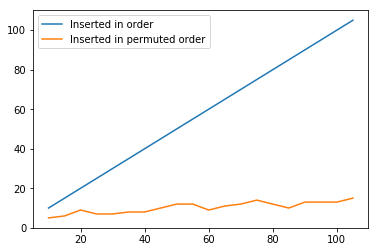

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [sequential_tree_size(n) for n in ns], label = "Inserted in order")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Inserted in permuted order")
ax.legend(loc='upper left')

When we insert the elements in sorted order, we get a maximally unbalanced tree. Each new element has to be inserted as the rightmost element in the new tree, and the result is a tree that consists of one long chain of nodes going to the right. If we inserted elements in the reverse order, we would get a similar tree that was left-heavy instead.

If we insert elements in random order, we alleviate this problem. We will, in fact, expect to get a reasonably balanced tree. Since a balanced tree of size $n$ has a depth in $O(\log n)$, the `insert` and `member` operations are much faster for balanced trees. Of course, since the actual depth depends on the random permutation, and since the $\log n$ optimal depth is only achieved for perfectly balanced trees, we expect the depth to be slightly higher than $\log n$, but our goals for this notebook is to implement a version of search trees that has worst-case depth between $\log n$ and $2\lceil\log(n)\rceil$.

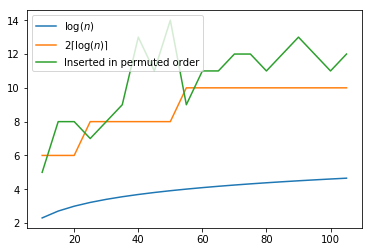

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log, ceil

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [log(n) for n in ns], label = r"$\log(n)$")
ax.plot(ns, [2*ceil(log(n)) for n in ns], label = r"$2\lceil\log(n)\rceil$")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Inserted in permuted order")
ax.legend(loc='upper left')

## Red-black search trees

The trick to getting good performance out of search trees is to keep them balanced. Inserting elements in a random order gets us an expected balanced tree, but we cannot always just permute input data and even if we could it would be *expected* logarithmic performance, not worst-case logarithmic performance. To get worst-case $O(\log n)$ operations, we need to explicitly rebalance trees when they become unbalanced.

One strategy for keeping trees balanced is the [red-black tree](https://en.wikipedia.org/wiki/Red–black_tree) data structure. Here, we assign a colour, either red or black, to each node in the tree.

In [6]:
RED = 0
BLACK = 1

class TreeNode:
    def __init__(self, value, colour, left = None, right = None):
        self.value = value
        self.colour = colour
        self.left = left
        self.right = right

The way we use these two colours to keep trees balanced is that we maintain the following three invariants:

1. All elements to the left subtree of a node are smaller than the value in the node, and all elements in the right subtree are larger.
2. All paths from root to a leaf have the same number of black nodes.
3. A red node cannot have a red parent.

The first invariant is just the search tree property. We need this invariant for all search trees for our `member` function to work correctly.

Together, the other two invariants guarantee that the longest path from root to a leaf is no longer than twice the length of the shortest. The depth of a tree with $n$ elements is therefore at most $2\lceil\log n\rceil$.

Whenever we modify a tree, which since we ignore `delete` in these exercises means whenever we insert an element, we need to ensure that the invariants are maintained. The `insert` function we have above already guarantee the search tree invariant, but we need to add a rebalancing step to it to guarantee the other two. Any new tree we create when we recurse in `insert`, we will rebalance before we return.

The code below does this. I have split the `insert` function in two. An `insert_recursion` function, that does the actual work, and an `insert` function that calls the `insert_recursion` function and sets the root colour to black. Setting the root colour to black will never invalidate any of the invariants. It might add a black node to all paths from root to a leaf, but that does not invalidate invariant two, and since we do not modify the tree structure or create any red nodes, the other two invariants are not affected by this. Setting the root colour to black, however, if it is already red, could ensure the third invariant in case any of the root's children are coloured red.

In [7]:
def insert(tree, value):
    tree = insert_recursion(tree, value)
    tree.colour = BLACK
    return tree

The `insert_recursion` function follows the same pattern as the original `insert` function, but we call a function to `rebalance` the tree we construct before we return:

In [8]:
def insert_recursion(tree, value):
    if tree is None:
        return TreeNode(value, RED)
    if tree.value == value:
        return tree
    elif tree.value < value:
        return rebalance(TreeNode(tree.value, tree.colour, tree.left, insert_recursion(tree.right, value)))
    else:
        return rebalance(TreeNode(tree.value, tree.colour, insert_recursion(tree.left, value), tree.right))

When we insert a new leaf, we colour it red. This cannot invalidate invariant two, but it might invalidate invariant three if the leaf we insert has a red parent. We use `rebalance` to transform trees that violate the "red parent to red child" invariant. The way we insert elements, we can at most have one violation of this invariant, and we will bubble it up the tree. There are four tree topologies where we have one violation of the rule, and for all of them, we transform the tree into another that satisfy all the invariants. The transformations look like this:

![](figures/RBT-transformations.png)

After the transformation, the local tree satisfy all invariants. The global tree might still violate invariant three, though, if the parent of the transformed tree is red. This, however, will be handled by the rebalancing function called earlier in the insertion recursion. Thus, the red node violating the invariant bubbles up towards the root, and if it reaches the root, we get rid of it when we colour the root black.

To implement this red-black strategy, all we have to do is make `rebalance` recognize the four cases and return the middle tree instead of them. We can split this function into two. One that tries to recognize the trees to be transformed, and one that does the transformation. The `rebalance` tree below handles the transformation in cases where the `match_tree_patern` function returns a match.

In [9]:
def rebalance(tree):
    is_match, a, b, c, d, x, y, z = match_tree_pattern(tree)
    if is_match:
        return TreeNode(y, colour = RED, 
                        left = TreeNode(x, colour = BLACK, left = a, right = b),
                        right = TreeNode(z, colour = BLACK, left = c, right = d))
    else:
        return tree

Now, all that remains, is implementing the `match_tree_pattern` function. We want it to return a boolean value indicating if the tree is a match, and if it is, it should match the trees and values indicated in the figure. The function below matches the first case. Implement the other three cases.

In [10]:
def match_tree_pattern(tree):
    if tree is not None and tree.left is not None and tree.left.right is not None and \
        tree.colour == BLACK and tree.left.colour == RED and tree.left.right.colour == RED:
            x, y, z = tree.left.value, tree.value, tree.left.right.value
            a, b = tree.left.left, tree.left.right.left
            c, d = tree.left.right.left, tree.right
            return True, a, b, c, d, x, y, z
        
    # Implement the other three matches
    
    return False, None, None, None, None, None, None, None

We can check that the new implementation works by creating some random trees and making sure that we can find all elements in them again:

In [11]:
ns = permutation(10)
tree = None
for n in ns:
    tree = insert(tree, n)
for n in ns:
    if not member(tree, n):
        print(n, "is missing from", display_tree(tree))
        
ns = permutation(10)
tree = None
for n in ns:
    tree = insert(tree, n)
for n in ns:
    if not member(tree, n):
        print(n, "is missing from", display_tree(tree))
        
ns = permutation(10)
tree = None
for n in ns:
    tree = insert(tree, n)
for n in ns:
    if not member(tree, n):
        print(n, "is missing from", display_tree(tree))

As a check that the balancing works, we can plot the depth of trees against $2\lceil\log n\rceil$. The depth should always be less than or equal to $2\lceil\log n\rceil$.

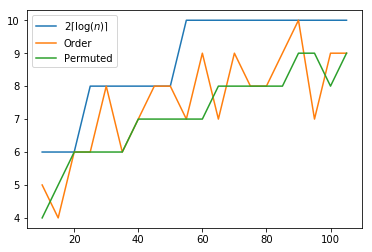

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log, ceil

ns = list(range(10,110,5))

fig, ax = plt.subplots()
ax.plot(ns, [2*ceil(log(n)) for n in ns], label = r"$2\lceil\log(n)\rceil$")
ax.plot(ns, [sequential_tree_size(n) for n in ns], label = "Order")
ax.plot(ns, [random_tree_size(n) for n in ns], label = "Permuted")
ax.legend(loc='upper left')

We can write a number of additional functions to validate the invariants and the balance of the tree. Do these exercises:

### Balance property

Write a function that computes the longest and the shortest path from root to a leaf. Use it to check that the longest path is at most twice the length of the shortest.

In [13]:
def check_balance_property(tree):
    pass

### Red property

Write a function that checks that no red child has a red parent.

In [14]:
def check_red_property(tree):
    pass

In a depth first recursion, it is probably easier to change the property to "no red parent has a red child". The property is the same, but it is easier to check the property in a recursion from the parent's perspective.

### Black property

Write a function that check that all paths from root to a leaf have the same number of black nodes.

In [15]:
def check_black_property(tree):
    pass

For this function, you could write a recursion that returns both a `True/False` value, indicating if a subtree satisfy the property, and the depth of the tree, to let you check that against its sibling. You would then wrap that in a function that just return the boolean value.

In [16]:
def check_black_property_recursion(tree):
    # do stuff
    return True, 0

def check_black_property(tree):
    satisfy_property, _ = check_black_property_recursion(tree)
    return satisfy_property